# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/data/Deep_learning

import os
print("Now in:", os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/data/Deep_learning
Now in: /content/drive/MyDrive/ColabNotebooks/data/Deep_learning


Download data with kagglehub

In [3]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [4]:
dataset = FashionDataset("dataset/train.csv",img_dir)
#dataset = FashionDataset("train.csv",img_dir)

In [ ]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


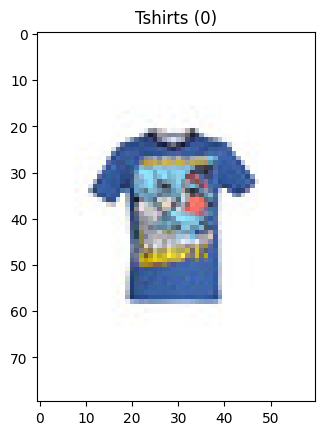

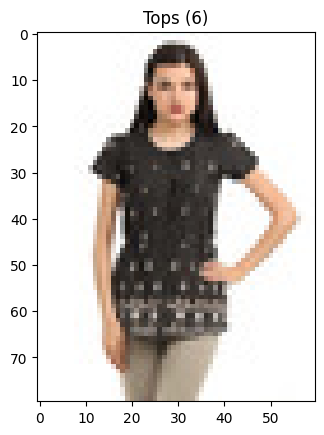

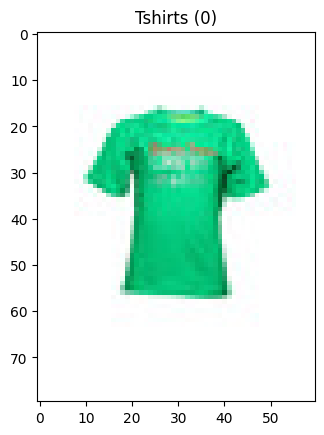

In [ ]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [5]:
transform = transforms.Compose([
    transforms.Resize((80, 80)), #resize to 80x80, because the original images have different sizes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)

# train_dataset = FashionDataset("train.csv",img_dir,transform=transform)
# main_test_dataset =  FashionDataset("main_test.csv",img_dir,transform=transform)
# new_test_dataset =  FashionDataset("new_test.csv",img_dir,transform=transform)
# main_support_dataset =  FashionDataset("main_support.csv",img_dir,transform=transform)
# new_support_dataset =  FashionDataset("new_support.csv",img_dir,transform=transform)
# merged_test_dataset =  FashionDataset("merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
# merged_support_dataset =  FashionDataset("merged_support.csv",img_dir,transform=transform)

# # datasets with categories
# main_test_dataset_cat =  FashionDataset("main_test.csv",img_dir,column_class="categoryId",transform=transform)
# main_support_dataset_cat =  FashionDataset("main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)}
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [6]:
#IMPORT ALL THE REQUIRED LIBRARIES

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier


### Model Architecture

In [29]:
class CNN(nn.Module):
    def __init__(self, num_classes, bw = 32, lr= 0.001):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3,  bw,  kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),

            nn.Conv2d(bw, bw, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),

            nn.Conv2d(bw*2, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw*2, bw*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*4),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p = 0.3),
            nn.Linear(bw*4, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x




### Helper Functions

In [39]:
#import with data loaders
def get_data(train_ds, valid_ds, test_ds, batch_size=64):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_dl, valid_dl, test_dl

def loss_batch(model, loss_func, xb, yb, opt=None):

    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)


    return loss.item(), corrects, len(xb), preds, yb


def fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl):
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    train_accs = []
    val_accs = []

    for epoch in tqdm(range(epochs)):


        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:

            # move data to GPU if available
            xb = xb.to(device)
            yb = yb.to(device)

            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums, *_ = loss_batch(model, loss_func, xb, yb,opt)

            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num
        train_accs.append(train_acc)


        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0

            all_preds, all_trues = [], []

            for xb, yb in valid_dl:

                xb = xb.to(device)
                yb = yb.to(device)


                # forward
                losses, corrects, nums, preds, yb = loss_batch(model, loss_func, xb, yb)

                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

                all_preds.append(preds.cpu())
                all_trues.append(yb.cpu())



            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            bacc = balanced_accuracy_score(torch.cat(all_trues), torch.cat(all_preds))

            val_accs.append(val_acc)

            scheduler.step(val_loss) # decrease the learning rate if validation loss increases


        # print the results
        print(
            f'EPOCH with LR {scheduler.get_last_lr()[0]}: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ', f"VAL-BACC: {bacc:.4f} ",end='\n')

        if val_acc >= 0.80 and bacc >= 0.8:
          print("Early Stopping")
          break

    plot_train(train_accs, val_accs)



### Learning curve


In [40]:
def plot_train(train_accs, test_accs):
      fig, ax = plt.subplots(figsize=(8,6))
      fnt=16
      # send to cpu
      train_accs = [t.cpu().numpy() for t in train_accs]
      test_accs = [t.cpu().numpy() for t in test_accs]
      ax.plot(train_accs, color='blue', label='Train')
      ax.plot(test_accs, color='red', linestyle='--', label='Test')
      ax.legend(fontsize=fnt)
      ax.tick_params(axis='both', labelsize=fnt)
      ax.set_xlabel('Epoch', fontsize=fnt)
      ax.set_ylabel('Accuracy', fontsize=fnt)

### Training the model

Using device: cuda


  1%|          | 1/100 [00:28<47:36, 28.85s/it]

EPOCH with LR 0.1: 001/100 LOSS: 2.4848 ACC: 0.3206  VAL-LOSS: 4.1743 VAL-ACC: 0.1847  VAL-BACC: 0.0679 


  2%|▏         | 2/100 [00:56<46:18, 28.35s/it]

EPOCH with LR 0.1: 002/100 LOSS: 1.6359 ACC: 0.5181  VAL-LOSS: 1.9392 VAL-ACC: 0.4202  VAL-BACC: 0.3028 


  3%|▎         | 3/100 [01:24<45:36, 28.21s/it]

EPOCH with LR 0.1: 003/100 LOSS: 1.2525 ACC: 0.6201  VAL-LOSS: 6.4028 VAL-ACC: 0.1985  VAL-BACC: 0.1413 


  4%|▍         | 4/100 [01:53<45:34, 28.48s/it]

EPOCH with LR 0.1: 004/100 LOSS: 1.0516 ACC: 0.6729  VAL-LOSS: 1.6078 VAL-ACC: 0.4991  VAL-BACC: 0.3232 


  5%|▌         | 5/100 [02:22<45:13, 28.57s/it]

EPOCH with LR 0.1: 005/100 LOSS: 0.9170 ACC: 0.7130  VAL-LOSS: 3.3787 VAL-ACC: 0.3751  VAL-BACC: 0.2922 


  6%|▌         | 6/100 [02:51<45:03, 28.76s/it]

EPOCH with LR 0.1: 006/100 LOSS: 0.8290 ACC: 0.7359  VAL-LOSS: 1.6445 VAL-ACC: 0.5185  VAL-BACC: 0.3656 


  7%|▋         | 7/100 [03:19<44:00, 28.39s/it]

EPOCH with LR 0.1: 007/100 LOSS: 0.7660 ACC: 0.7546  VAL-LOSS: 0.8920 VAL-ACC: 0.7257  VAL-BACC: 0.5657 


  8%|▊         | 8/100 [03:46<43:08, 28.14s/it]

EPOCH with LR 0.1: 008/100 LOSS: 0.7060 ACC: 0.7749  VAL-LOSS: 3.0622 VAL-ACC: 0.4001  VAL-BACC: 0.2471 


  9%|▉         | 9/100 [04:14<42:14, 27.85s/it]

EPOCH with LR 0.1: 009/100 LOSS: 0.6675 ACC: 0.7819  VAL-LOSS: 3.0221 VAL-ACC: 0.4139  VAL-BACC: 0.2758 


 10%|█         | 10/100 [04:41<41:40, 27.79s/it]

EPOCH with LR 0.1: 010/100 LOSS: 0.6431 ACC: 0.7920  VAL-LOSS: 0.8098 VAL-ACC: 0.7458  VAL-BACC: 0.5981 


 11%|█         | 11/100 [05:09<41:14, 27.80s/it]

EPOCH with LR 0.1: 011/100 LOSS: 0.6048 ACC: 0.8017  VAL-LOSS: 2.2338 VAL-ACC: 0.5072  VAL-BACC: 0.3269 


 12%|█▏        | 12/100 [05:37<40:53, 27.88s/it]

EPOCH with LR 0.1: 012/100 LOSS: 0.5777 ACC: 0.8105  VAL-LOSS: 1.9284 VAL-ACC: 0.5441  VAL-BACC: 0.4445 


 13%|█▎        | 13/100 [06:05<40:20, 27.82s/it]

EPOCH with LR 0.1: 013/100 LOSS: 0.5661 ACC: 0.8121  VAL-LOSS: 11.8485 VAL-ACC: 0.3081  VAL-BACC: 0.1493 


 14%|█▍        | 14/100 [06:33<39:53, 27.84s/it]

EPOCH with LR 0.05: 014/100 LOSS: 0.5448 ACC: 0.8209  VAL-LOSS: 2.4171 VAL-ACC: 0.5128  VAL-BACC: 0.3002 


 15%|█▌        | 15/100 [07:00<39:20, 27.77s/it]

EPOCH with LR 0.05: 015/100 LOSS: 0.4857 ACC: 0.8393  VAL-LOSS: 0.9605 VAL-ACC: 0.7113  VAL-BACC: 0.5309 


 16%|█▌        | 16/100 [07:28<38:56, 27.82s/it]

EPOCH with LR 0.05: 016/100 LOSS: 0.4666 ACC: 0.8440  VAL-LOSS: 1.1633 VAL-ACC: 0.6688  VAL-BACC: 0.5016 


 17%|█▋        | 17/100 [07:57<38:54, 28.13s/it]

EPOCH with LR 0.05: 017/100 LOSS: 0.4587 ACC: 0.8486  VAL-LOSS: 0.4935 VAL-ACC: 0.8422  VAL-BACC: 0.7328 


 18%|█▊        | 18/100 [08:25<38:26, 28.13s/it]

EPOCH with LR 0.05: 018/100 LOSS: 0.4453 ACC: 0.8513  VAL-LOSS: 1.3526 VAL-ACC: 0.6544  VAL-BACC: 0.5027 


 19%|█▉        | 19/100 [08:54<38:15, 28.34s/it]

EPOCH with LR 0.05: 019/100 LOSS: 0.4362 ACC: 0.8562  VAL-LOSS: 0.6757 VAL-ACC: 0.7790  VAL-BACC: 0.7058 


 20%|██        | 20/100 [09:22<37:39, 28.24s/it]

EPOCH with LR 0.05: 020/100 LOSS: 0.4311 ACC: 0.8567  VAL-LOSS: 1.0583 VAL-ACC: 0.7082  VAL-BACC: 0.5519 


 21%|██        | 21/100 [09:50<37:02, 28.13s/it]

EPOCH with LR 0.025: 021/100 LOSS: 0.4256 ACC: 0.8569  VAL-LOSS: 0.6950 VAL-ACC: 0.7821  VAL-BACC: 0.6809 


 22%|██▏       | 22/100 [10:17<36:19, 27.94s/it]

EPOCH with LR 0.025: 022/100 LOSS: 0.3945 ACC: 0.8670  VAL-LOSS: 0.3957 VAL-ACC: 0.8704  VAL-BACC: 0.7747 


 23%|██▎       | 23/100 [10:46<36:10, 28.19s/it]

EPOCH with LR 0.025: 023/100 LOSS: 0.3865 ACC: 0.8704  VAL-LOSS: 0.4054 VAL-ACC: 0.8629  VAL-BACC: 0.7546 


 24%|██▍       | 24/100 [11:14<35:42, 28.19s/it]

EPOCH with LR 0.025: 024/100 LOSS: 0.3791 ACC: 0.8742  VAL-LOSS: 0.6963 VAL-ACC: 0.7846  VAL-BACC: 0.6318 


 25%|██▌       | 25/100 [11:42<35:12, 28.16s/it]

EPOCH with LR 0.025: 025/100 LOSS: 0.3759 ACC: 0.8722  VAL-LOSS: 0.5177 VAL-ACC: 0.8391  VAL-BACC: 0.7381 


 26%|██▌       | 26/100 [12:10<34:29, 27.96s/it]

EPOCH with LR 0.0125: 026/100 LOSS: 0.3722 ACC: 0.8749  VAL-LOSS: 0.4340 VAL-ACC: 0.8528  VAL-BACC: 0.7558 


 27%|██▋       | 27/100 [12:39<34:26, 28.31s/it]

EPOCH with LR 0.0125: 027/100 LOSS: 0.3547 ACC: 0.8801  VAL-LOSS: 0.4675 VAL-ACC: 0.8391  VAL-BACC: 0.7729 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cdb3cac45e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
 28%|██▊       | 28/100 [13:08<34:00, 28.35s/it]

EPOCH with LR 0.0125: 028/100 LOSS: 0.3484 ACC: 0.8826  VAL-LOSS: 0.3879 VAL-ACC: 0.8735  VAL-BACC: 0.7969 


 29%|██▉       | 29/100 [13:36<33:44, 28.52s/it]

EPOCH with LR 0.0125: 029/100 LOSS: 0.3452 ACC: 0.8837  VAL-LOSS: 0.3903 VAL-ACC: 0.8773  VAL-BACC: 0.7998 


 30%|███       | 30/100 [14:04<32:54, 28.21s/it]

EPOCH with LR 0.0125: 030/100 LOSS: 0.3441 ACC: 0.8877  VAL-LOSS: 0.3682 VAL-ACC: 0.8804  VAL-BACC: 0.7997 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cdb3cac45e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cdb3cac45e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

EPOCH with LR 0.0125: 031/100 LOSS: 0.3444 ACC: 0.8840  VAL-LOSS: 0.3748 VAL-ACC: 0.8854  VAL-BACC: 0.8044 
Early Stopping


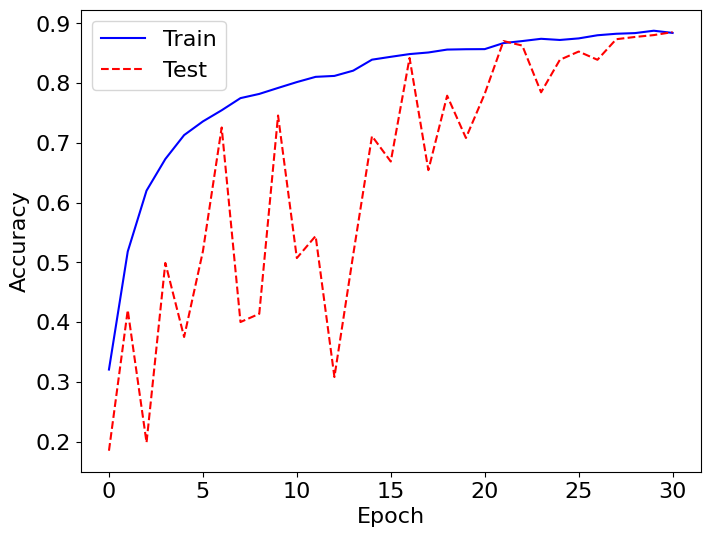

In [43]:
epochs=100
lr = 0.1

model = CNN(num_classes=39)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3) # decrease the learning rate if validation loss increases
loss_func = F.cross_entropy

# Split the main_test_dataset
valid_size = int(0.8 * len(main_test_dataset))
holdout_size = len(main_test_dataset) - valid_size
valid_dataset, holdout_dataset = random_split(main_test_dataset, [valid_size, holdout_size])

train_dl, valid_dl, holdout_dl = get_data(train_dataset, valid_dataset, holdout_dataset,batch_size=526) # you have to decrease batch size for lower RAM gpus/cpus


fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl)

### Saving the model

In [45]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'fashion_model_weights.pth')

### Evaluate on test set

In [49]:

def evaluate_model(model, holdout_dl):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():  # No gradients needed for evaluation
        for x, y in holdout_dl:
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda()

            outputs = model(x)
            _, preds = torch.max(outputs, 1)

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Calculate metrics
    accuracy = total_correct / total_samples
    balanced_acc = balanced_accuracy_score(all_targets, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    return accuracy, balanced_acc

# model and weights
model = CNN(num_classes=39)  # Initialize with the same architecture
# model.load_state_dict(torch.load('models/fashion_model_weights.pth'))
model.load_state_dict(torch.load('fashion_model_weights.pth'))

if torch.cuda.is_available():
    model = model.cuda()

# 3. Evaluate on the new test dataset
accuracy, balanced_accuracy = evaluate_model(model, holdout_dl)

Test Accuracy: 0.8425
Balanced Accuracy: 0.7919


## Task 2

In [ ]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

Steps:

1. Define embedding (mapping) network  f(x)  - EmbeddingNet , to extract embedding of each sample (anchor, positive and negative image ) in triplets.

2. Create BalancedBatchSampler - samples  N  classes and  M  samples for each class to form a minibatch, and create a dataloader with the batch sampler.

3. Define a TripletSelector that return triplets combinations by the samples from BalancedBatchSampler

4. Define TripletLoss that will use a TripletSelector and compute TripletLoss on triplets

5. Train the network!

###  Embedding Net

In [50]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    def __init__(self, bw = 32, lr= 0.001, embedding_dim=39):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            nn.Conv2d(3,  bw,  kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),

            nn.Conv2d(bw, bw, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),

            nn.Conv2d(bw*2, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw*2, bw*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*4),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.embedding_layer = nn.Linear(bw*4, embedding_dim)

    def forward(self, x):
        features = self.front_layer(x)
        embedding = self.embedding_layer(features)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding

    def get_embedding(self, x):
        return self.forward(x)


### Balanced Batch Sampler and Data Loader

In [57]:
from torch.utils.data.sampler import BatchSampler

class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [58]:
train_batch_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=39, n_samples=8)
test_batch_sampler = BalancedBatchSampler(main_test_dataset.targets, n_classes=39, n_samples=8)

triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_test_loader = torch.utils.data.DataLoader(main_test_dataset, batch_sampler=test_batch_sampler)

### Informative Triplet Selector

In [59]:
from itertools import combinations
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix
class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()

        self.margin = margin

   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):

        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None


    def get_triplets(self, embeddings, labels):

        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)


            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()

                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

### Triplet Loss

In [60]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

### Training the  model

In [61]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):

            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss

                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [62]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_test_loader,
                  epochs=30)

# start training
trainer.run_trainer()

  3%|▎         | 1/30 [01:09<33:26, 69.21s/it]

EPOCH: 01/30 LOSS: 0.8405 VAL-LOSS: 0.7255


  7%|▋         | 2/30 [02:18<32:19, 69.26s/it]

EPOCH: 02/30 LOSS: 0.6459 VAL-LOSS: 0.5833


 10%|█         | 3/30 [03:27<31:06, 69.13s/it]

EPOCH: 03/30 LOSS: 0.5688 VAL-LOSS: 0.5576


 13%|█▎        | 4/30 [04:37<30:02, 69.34s/it]

EPOCH: 04/30 LOSS: 0.5277 VAL-LOSS: 0.4988


 17%|█▋        | 5/30 [05:46<28:55, 69.43s/it]

EPOCH: 05/30 LOSS: 0.5005 VAL-LOSS: 0.4767


 20%|██        | 6/30 [06:56<27:51, 69.63s/it]

EPOCH: 06/30 LOSS: 0.4807 VAL-LOSS: 0.4542


 23%|██▎       | 7/30 [08:08<26:55, 70.25s/it]

EPOCH: 07/30 LOSS: 0.4678 VAL-LOSS: 0.4470


 27%|██▋       | 8/30 [09:19<25:51, 70.51s/it]

EPOCH: 08/30 LOSS: 0.4605 VAL-LOSS: 0.4417


 30%|███       | 9/30 [10:28<24:29, 69.99s/it]

EPOCH: 09/30 LOSS: 0.4537 VAL-LOSS: 0.4619


 33%|███▎      | 10/30 [11:37<23:16, 69.81s/it]

EPOCH: 10/30 LOSS: 0.4444 VAL-LOSS: 0.4283


 37%|███▋      | 11/30 [12:46<22:00, 69.49s/it]

EPOCH: 11/30 LOSS: 0.4401 VAL-LOSS: 0.4055


 40%|████      | 12/30 [13:54<20:45, 69.21s/it]

EPOCH: 12/30 LOSS: 0.4355 VAL-LOSS: 0.3940


 43%|████▎     | 13/30 [15:02<19:29, 68.81s/it]

EPOCH: 13/30 LOSS: 0.4301 VAL-LOSS: 0.4087


 47%|████▋     | 14/30 [16:11<18:19, 68.71s/it]

EPOCH: 14/30 LOSS: 0.4310 VAL-LOSS: 0.3787


 50%|█████     | 15/30 [17:20<17:13, 68.91s/it]

EPOCH: 15/30 LOSS: 0.4275 VAL-LOSS: 0.4008


 53%|█████▎    | 16/30 [18:28<16:01, 68.68s/it]

EPOCH: 16/30 LOSS: 0.4273 VAL-LOSS: 0.3866


 57%|█████▋    | 17/30 [19:36<14:48, 68.37s/it]

EPOCH: 17/30 LOSS: 0.4259 VAL-LOSS: 0.3910


 60%|██████    | 18/30 [20:44<13:41, 68.42s/it]

EPOCH: 18/30 LOSS: 0.4223 VAL-LOSS: 0.3859


 63%|██████▎   | 19/30 [21:54<12:35, 68.70s/it]

EPOCH: 19/30 LOSS: 0.4194 VAL-LOSS: 0.3977


 67%|██████▋   | 20/30 [23:02<11:25, 68.57s/it]

EPOCH: 20/30 LOSS: 0.4196 VAL-LOSS: 0.3619


 70%|███████   | 21/30 [24:10<10:14, 68.30s/it]

EPOCH: 21/30 LOSS: 0.4176 VAL-LOSS: 0.3869


 73%|███████▎  | 22/30 [25:18<09:05, 68.19s/it]

EPOCH: 22/30 LOSS: 0.4189 VAL-LOSS: 0.3793


 77%|███████▋  | 23/30 [26:27<08:00, 68.58s/it]

EPOCH: 23/30 LOSS: 0.4159 VAL-LOSS: 0.3904


 80%|████████  | 24/30 [27:36<06:51, 68.66s/it]

EPOCH: 24/30 LOSS: 0.4165 VAL-LOSS: 0.3782


 83%|████████▎ | 25/30 [28:45<05:43, 68.76s/it]

EPOCH: 25/30 LOSS: 0.4120 VAL-LOSS: 0.3673


 87%|████████▋ | 26/30 [29:54<04:34, 68.74s/it]

EPOCH: 26/30 LOSS: 0.4111 VAL-LOSS: 0.3594


 90%|█████████ | 27/30 [31:02<03:25, 68.65s/it]

EPOCH: 27/30 LOSS: 0.4102 VAL-LOSS: 0.3398


 93%|█████████▎| 28/30 [32:11<02:17, 68.58s/it]

EPOCH: 28/30 LOSS: 0.4103 VAL-LOSS: 0.3672


 97%|█████████▋| 29/30 [33:19<01:08, 68.56s/it]

EPOCH: 29/30 LOSS: 0.4088 VAL-LOSS: 0.3411


100%|██████████| 30/30 [34:27<00:00, 68.93s/it]

EPOCH: 30/30 LOSS: 0.4055 VAL-LOSS: 0.3590


### Save the embedding model

In [63]:
torch.save(model.state_dict(), 'embedding_model.pth')

A help funtion to extract the embedding

In [65]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(main_test_dataset, batch_size=256)

def extract_embeddings(dataloader, model):

    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 39))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(train_loader, model)
val_embeddings, val_labels = extract_embeddings(test_loader, model)

### Visualize the embeddings in 2-d space

In [66]:
labels = list(label_id_to_label_name.values())

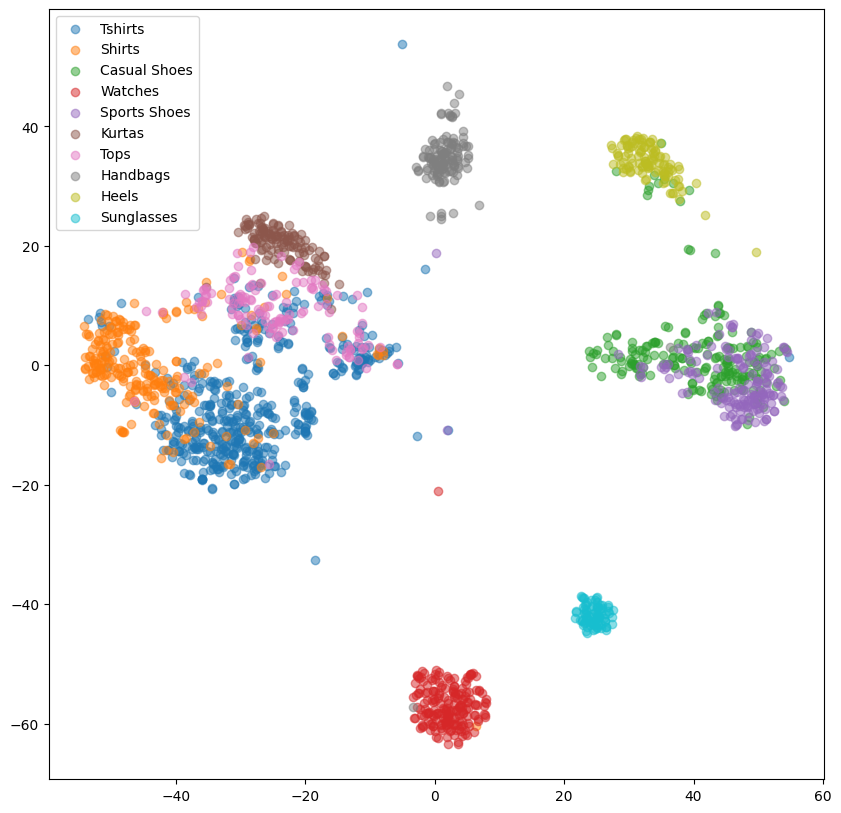

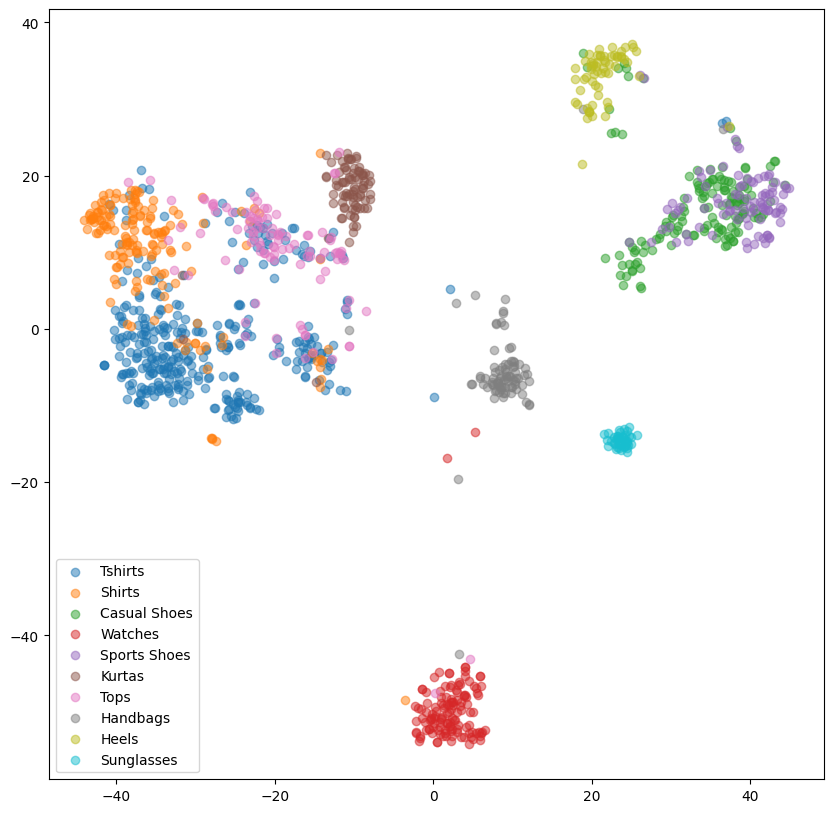

In [67]:
from sklearn.manifold import TSNE
def plot_tsne_embeddings(embeddings, targets, xlim=None, ylim=None):


    # The first 3000 embeddings and targets
    embeddings= embeddings[:3000]
    targets= targets[:3000]

    # Using Tsne to for dimension reduction
    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(labels)

plot_tsne_embeddings(train_embeddings, train_labels)
plot_tsne_embeddings(val_embeddings, val_labels)


Now we need to:
1. Compute the embeddings for the support set images.
2. Compute the embedding for the test set images
3. Find the k-nearest kneighbours from the support set
4. Classify the test images based on the labels from the k-nearest kneighbours (so we don't need to retrain the model and can classify unseen classes/labels)


### Load the embedding model

In [68]:
# Load the model
embedding_net = EmbeddingNet().to(device)
embedding_net.load_state_dict(torch.load('embedding_model.pth'))



<All keys matched successfully>

### Create embedding support classifier

In [69]:
class EmbeddingSupportClassifier:
    """
    A classifier that uses embeddings from a support set to classify test images.
    This allows classification of new classes without retraining the model.
    """
    def __init__(self, model, device, k=5):
        self.model = model
        self.device = device
        self.k = k
        self.knn = None
        self.support_embeddings = None
        self.support_labels = None

    def extract_embeddings(self, dataloader):
        self.model.eval()
        embeddings = []
        labels = []

        with torch.no_grad():
            for images, targets in tqdm(dataloader, desc="Extracting embeddings"):
                images = images.to(self.device)
                batch_embeddings = self.model.get_embedding(images).cpu().numpy()
                embeddings.append(batch_embeddings)
                labels.append(targets.numpy())

        embeddings = np.vstack(embeddings)
        labels = np.concatenate(labels)

        return embeddings, labels

    def fit_support_set(self, support_loader):
        print("Fitting support set...")
        self.support_embeddings, self.support_labels = self.extract_embeddings(support_loader)
        self.knn = KNeighborsClassifier(n_neighbors=self.k, metric='euclidean')
        self.knn.fit(self.support_embeddings, self.support_labels)
        print(f"Support set fitted with {len(self.support_labels)} samples")

    def predict(self, test_loader):
        if self.knn is None:
            raise ValueError("Support set must be fitted before prediction")

        test_embeddings, test_labels = self.extract_embeddings(test_loader)
        predicted_labels = self.knn.predict(test_embeddings)

        return test_labels, predicted_labels

    def evaluate(self, test_loader):
        true_labels, predicted_labels = self.predict(test_loader)

        acc = accuracy_score(true_labels, predicted_labels)
        balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

        return acc,balanced_acc

### Create dataloaders

In [70]:
batch_size=526
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
main_test_dl = DataLoader(main_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
new_test_dl = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
main_support_dl = DataLoader(main_support_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
new_support_dl = DataLoader(new_support_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
merged_test_dl = DataLoader(merged_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
merged_support_dl = DataLoader(merged_support_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


### Function to run all the scenarios

In [71]:
# Function to run all the scenarios
def evaluate_all_scenarios(model, device, k_values=[1, 3]):
    """
    Evaluate the model on all scenarios with different k values

    Args:
        model: Trained embedding model
        device: Device to run the model on
        k_values: List of k values to try for KNN

    Returns:
        best_results: Dictionary with best results for all scenarios
    """
    loaders = {
        'train': train_dl,
        'main_test': main_test_dl,
        'new_test': new_test_dl,
        'main_support': main_support_dl,
        'new_support': new_support_dl,
        'merged_test': merged_test_dl,
        'merged_support': merged_support_dl
    }

    best_results = {}
    best_k = {}

    for scenario_num, (support_name, test_name) in enumerate([
        ('train', 'main_test'),           # Scenario 1
        ('main_support', 'main_test'),    # Scenario 2
        ('new_support', 'new_test'),      # Scenario 3
        ('merged_support', 'merged_test') # Scenario 4
    ], 1):
        scenario_results = []

        for k in k_values:
            classifier = EmbeddingSupportClassifier(model, device, k=k)
            classifier.fit_support_set(loaders[support_name])
            acc, bal_acc = classifier.evaluate(loaders[test_name])
            scenario_results.append((k, acc, bal_acc))
            print(f"Scenario {scenario_num}, k={k}: Accuracy = {acc:.4f}, Balanced Accuracy = {bal_acc:.4f}")

        # Find best k based on balanced accuracy
        best_k_idx = np.argmax([r[2] for r in scenario_results])
        best_k[f'scenario{scenario_num}'] = scenario_results[best_k_idx][0]
        best_results[f'scenario{scenario_num}'] = {
            'k': scenario_results[best_k_idx][0],
            'accuracy': scenario_results[best_k_idx][1],
            'balanced_accuracy': scenario_results[best_k_idx][2]
        }

    # Print summary of best results
    print("\nBest Results Summary:")
    for scenario in range(1, 5):
        result = best_results[f'scenario{scenario}']
        print(f"Scenario {scenario}: Best k={result['k']}, Accuracy={result['accuracy']:.4f}, Balanced Accuracy={result['balanced_accuracy']:.4f}")

    return best_results, best_k

### Run all the scenarios

In [72]:
 # Evaluate all scenarios
best_results, best_k_values = evaluate_all_scenarios(
    embedding_net, device
)

Fitting support set...


Extracting embeddings: 100%|██████████| 69/69 [00:13<00:00,  4.96it/s]


Support set fitted with 35934 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Scenario 1, k=1: Accuracy = 0.8177, Balanced Accuracy = 0.7731
Fitting support set...


Extracting embeddings: 100%|██████████| 69/69 [00:13<00:00,  5.04it/s]


Support set fitted with 35934 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Scenario 1, k=3: Accuracy = 0.8202, Balanced Accuracy = 0.7677
Fitting support set...


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Support set fitted with 1996 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Scenario 2, k=1: Accuracy = 0.7546, Balanced Accuracy = 0.7154
Fitting support set...


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Support set fitted with 1996 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Scenario 2, k=3: Accuracy = 0.7712, Balanced Accuracy = 0.7121
Fitting support set...


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Support set fitted with 1659 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Scenario 3, k=1: Accuracy = 0.7398, Balanced Accuracy = 0.7495
Fitting support set...


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Support set fitted with 1659 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Scenario 3, k=3: Accuracy = 0.7289, Balanced Accuracy = 0.7098
Fitting support set...


Extracting embeddings: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Support set fitted with 3655 samples


Extracting embeddings: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


Scenario 4, k=1: Accuracy = 0.6724, Balanced Accuracy = 0.6484
Fitting support set...


Extracting embeddings: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]


Support set fitted with 3655 samples


Extracting embeddings: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Scenario 4, k=3: Accuracy = 0.6760, Balanced Accuracy = 0.6302

Best Results Summary:
Scenario 1: Best k=1, Accuracy=0.8177, Balanced Accuracy=0.7731
Scenario 2: Best k=1, Accuracy=0.7546, Balanced Accuracy=0.7154
Scenario 3: Best k=1, Accuracy=0.7398, Balanced Accuracy=0.7495
Scenario 4: Best k=1, Accuracy=0.6724, Balanced Accuracy=0.6484


In [73]:
# Print summary
print("\nEvaluation Summary:")
scenarios = [
    "Scenario 1: Main classes train → Main classes test",
    "Scenario 2: Main classes support → Main classes test",
    "Scenario 3: New classes support → New classes test",
    "Scenario 4: Main+New classes support → Main+New classes test"
]

# Display the results
for i, key in enumerate(best_results, 1):
    data = best_results[key]
    print(f"{scenarios[i - 1]}")
    print(f"  k: {data['k']}")
    print(f"  Accuracy: {data['accuracy']:.4f}")
    print(f"  Balanced Accuracy: {data['balanced_accuracy']:.4f}")
    print()



Evaluation Summary:
Scenario 1: Main classes train → Main classes test
  k: 1
  Accuracy: 0.8177
  Balanced Accuracy: 0.7731

Scenario 2: Main classes support → Main classes test
  k: 1
  Accuracy: 0.7546
  Balanced Accuracy: 0.7154

Scenario 3: New classes support → New classes test
  k: 1
  Accuracy: 0.7398
  Balanced Accuracy: 0.7495

Scenario 4: Main+New classes support → Main+New classes test
  k: 1
  Accuracy: 0.6724
  Balanced Accuracy: 0.6484



## Task 3

In [ ]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

## Task 4

In [ ]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset